In [1]:
import datacube 
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import numpy as np

from scipy.stats import cumfreq
from otps import TimePoint, predict_tide
# from otps import predict_tide
from dea_tools.dask import create_local_dask_cluster

import sys
sys.path.append("../Tools/dea_tools")
from coastal_temp import (select_aoi, 
                          exp_model, 
                          prep_aoi, 
                          plot_summary)


In [2]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36161 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/36161/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/36161/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46683,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/36161/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:36189,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/35523/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:46491,


In [3]:
m, master_gdf, roi = select_aoi()
display (m)

Map(center=[-32.13054578933222, 136.10234378608968], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [5]:
## Following selection of your area of interest using the shape options in the map menu
## and your tide-modelling position, using the `marker` option, run this cell to
## prepare the selections for analysis. Note that this is a per-pixel analysis. Consequently,
## a small area of interest is advised to minimise computation time.

tp, working_gdf, geom = prep_aoi(roi, master_gdf)

In [6]:
tp

[122.107544, -17.986489]

In [7]:
## Set the user-defined variables 

## Define the tidal-modelling period start and end dates. This is the period over which intertidal
## exposure will be calculated. Ideally, this period should be an 18.6 year window to account
## for the full average range of astronomical forcings on the tide (e.g. Haigh et al., 2011).
## However, a shorter window is advised in this application to minimise the computation time.
## Note that if a filter is applied to the tide-model, e.g. restricted date or tide range, then
## a wide tidal-modelling period may be achievable on this platform.

## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '1985-12-01 00:00:00'
time_end = '2023-01-01 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# ## Set the filter to apply for the exposure modelling. Options:
'''
    'all_time',
    'daynight',
    'springneap',
    'wet',
    'dry',
    'summer',
    'autumn',
    'winter',
    'spring',
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
'''
time_filter = ['all_time']

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 100000, "y": 100000},
    "geopolygon": geom
        }

In [8]:
ds = dc.load(**query)
ds2 = ds.where(ds.nidem > ds.nidem.min())

In [9]:
ds2 = ds2.compute()

In [ ]:
import xarray as xr

In [10]:
def exp_model(time_start, 
              time_end, 
              time_filter, 
              modelled_freq, 
              tidepost_lat, 
              tidepost_lon, 
              ds):      
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})
    
    print ('Complete: Tidal modelling. Starting: Local timezone conversion')

    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
    modelledtides.drop('timerange', axis=1, inplace=True)
    
#     '''
#     Solar modelling section
#     '''
    
#         ## Create all required time filters
#     ## Create dict to store filtered times
#     filters = {}
    
#     ## Create a filteredtides dataframe for the filters of interest
#     for x in time_filter:
        
#         if x == 'all_time':
#             filteredtides = modelledtides
#             filters[str(x)] = filteredtides
#     '''
#     All the other filters go here
#     '''
#         else:
#             print('''
#             Please select one of the following `time_filter`s: 
#             all_time, day, night, springneap, wet, dry, summer, autumn, winter, 
#             spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, 'wet_springneap'
#             ''')
    
#         print ('Complete: datetime filtering. Starting: wet/dry masking')
    
#     ## Create wet/dry boolean for each timestep per filter
#     WetDry = {}
#     for key in filters:
                
#         ## Boolean mask all modelled timesteps by tideheight relative to NIDEM:
#         da_list = list(ds.nidem >= filters[str(key)]['tideheights'][timestep] 
#                        for timestep in filters[str(key)].loc[time_start:time_end].index) 

#         index_list = list(timestep for timestep in filters[str(key)][time_start:time_end].index)

#         ## Store modelled datetimes as a pandas index
#         index = pd.Index(index_list, name='datetime')

#         ## Concatenate the arrays on the new dimension 'datetime'
#         exp_ds = xr.concat(da_list, index)
        
#         WetDry[str(key)] = exp_ds
        
#     print ('Complete: wet/dry masking. Starting: exposure calculations')
    
#     '''--------------------------------------------'''
#     ## Calculate the pc exposure per pixel for each filter
#     ## Build empty xr.ds and append each new da during looping through WetDry
    
#     pxpc2 = ds#.squeeze().reset_coords() ## Copy of NIDEM ds to append exposure results into
    
#     for f in WetDry:
    
#             ## Calculate the mean of the boolean across the datetime axis (equiv. to % True)
#         pxpc = WetDry[str(f)].mean('datetime')

# #         # Compute the array from dask
# #         pxpc = pxpc.compute() #%timeit

#         ## Name the exposure time array
#         pxpc = pxpc.rename('Exposure time (%)')

#         ## Mask out non-intertidal areas
#         pxpc = pxpc.where(pxpc > 0) ############################TEMP masked to capture 0% fraction 22/07/2022. Add back in for regular exposure modelling. CP
        
#         ## Append filter (f) exposure results into results dataset (pxpc2)
#         pxpc2[str(f)] = pxpc#.drop('time')

#     print('Complete: exposure calculations. Starting: ds.compute')
#     pxpc2 = pxpc2.compute()    
#     print ('Complete: ds.compute')

    return modelledtides#, filters, pxpc2

In [11]:
modelledtides_neg_lat = exp_model(time_start,
                                  time_end,
                                  time_filter,
                                  modelled_freq,
                                  tidepost_lat = tp[1],# = -17.420604,
                                  tidepost_lon = tp[0],# = 140.665169,
                                  ds=ds2)

Complete: Tidal modelling. Starting: Local timezone conversion
Timezone set to Australia/West


In [13]:
## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html



In [147]:
## Extract modelled tideheights as np.array
modelledtides = (np.array(modelledtides_neg_lat.tideheights))

## Calculate number of bins to use in cumulative frequency calculation, ensuring continentally consistent bin size of 0.1m (arbitrary bin size)
binsize = 0.1
bins = (modelledtides_neg_lat.tideheights.max() - modelledtides_neg_lat.tideheights.min())/binsize

## Calculate cumulative frequencies
res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# Calculate space of values for x
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

In [148]:
# plt.axhline(y=0.0, linestyle='-', color='r')
# plt.plot(modelledtides[:500], marker='o')

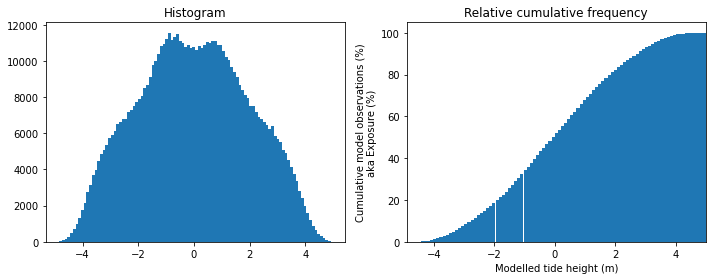

In [149]:


fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(modelledtides, bins=100)
ax1.set_title('Histogram')
ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
ax2.set_title('Relative cumulative frequency')
ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
ax2.set_xlabel('Modelled tide height (m)')
ax2.set_xlim([x.min(), x.max()])
fig.tight_layout()

In [150]:
## Save the relative cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights
testdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
test = pd.DataFrame(data=testdict)

## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
shifted = test.tideheight_max.shift(periods=1)
updatedvalue = test.tideheight_max[0] - binsize
shifted.update(pd.Series([updatedvalue], index=[0]))

test['tideheight_min']=shifted

# print(test)

In [151]:
# print (test)
# print(nidem_df[450:500])
# ds2.nidem.plot()
# notna = nidem_df.notna()
Nn = nidem_df.where(nidem_df.nidem.notna() == 'True')
Nn

spatial_ref  nidem  Exposure
time       y          x                                       
2001-07-02 -1950137.5 -1052537.5          NaN    NaN       NaN
                      -1052512.5          NaN    NaN       NaN
                      -1052487.5          NaN    NaN       NaN
                      -1052462.5          NaN    NaN       NaN
                      -1052437.5          NaN    NaN       NaN
...                                       ...    ...       ...
           -2001062.5 -1007937.5          NaN    NaN       NaN
                      -1007912.5          NaN    NaN       NaN
                      -1007887.5          NaN    NaN       NaN
                      -1007862.5          NaN    NaN       NaN
                      -1007837.5          NaN    NaN       NaN

[3645982 rows x 3 columns]

In [135]:
## Slow loop through both dataframes assessing exposure values for every nidem pixel

nidem_df['Exposure'] = pd.Series()

for i, d in nidem_df..iterrows():
    
    for ii, dd in test.iterrows():
        
        if (d.nidem >= dd.tideheight_min) & (d.nidem < dd.tideheight_max):
            
            nidem_df.Exposure.update(pd.Series([dd.cumfreq], index=[i]))


/tmp/ipykernel_118/3153117421.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  nidem_df['Exposure'] = pd.Series()


11.209838793775695
14.945067452523297
18.31423293614966
22.79850683138484
31.061844681548106
39.6091122045155
46.58292330668865
55.75726627712213
67.21442842618983
77.18303620180232
84.48030564737043
88.18261938196846
13.130439998708013
16.59696598227208
20.351420648116388
25.77592319440877
33.87668592856231
43.85144602644576
55.06497621358402
62.35640095299472
69.56230841283929
79.33573376440604
85.38008277949616
89.01610524162477
12.276343859444045
15.889448921113386
19.826166134234445
23.940685460985815
31.061844681548106
43.85144602644576
54.4042168016845
62.35640095299472
67.21442842618983
77.18303620180232
84.92850232480878
88.59882398359791
12.276343859444045
15.889448921113386
20.090254567714766
24.231690304401525
31.061844681548106
43.85144602644576
55.75726627712213
64.11873366750697
69.56230841283929
77.18303620180232
85.82766422470742
12.276343859444045
15.889448921113386
20.887595534029263
28.00844713847801
33.87668592856231
43.85144602644576
55.75726627712213
66.189143919

KeyboardInterrupt: 

In [136]:
nidem_df

spatial_ref  nidem  Exposure
time       y          x                                       
2001-07-02 -1950137.5 -1052537.5         3577    NaN       NaN
                      -1052512.5         3577    NaN       NaN
                      -1052487.5         3577    NaN       NaN
                      -1052462.5         3577    NaN       NaN
                      -1052437.5         3577    NaN       NaN
...                                       ...    ...       ...
           -2001062.5 -1007937.5         3577    NaN       NaN
                      -1007912.5         3577    NaN       NaN
                      -1007887.5         3577    NaN       NaN
                      -1007862.5         3577    NaN       NaN
                      -1007837.5         3577    NaN       NaN

[3645982 rows x 3 columns]

In [137]:
ds3 = nidem_df.to_xarray()
ds3

<xarray.Dataset>
Dimensions:      (time: 1, y: 2038, x: 1789)
Coordinates:
  * time         (time) datetime64[ns] 2001-07-02
  * y            (y) float64 -1.95e+06 -1.95e+06 ... -2.001e+06 -2.001e+06
  * x            (x) float64 -1.053e+06 -1.053e+06 ... -1.008e+06 -1.008e+06
Data variables:
    spatial_ref  (time, y, x) int32 3577 3577 3577 3577 ... 3577 3577 3577 3577
    nidem        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Exposure     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

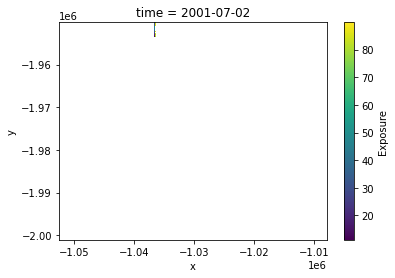

In [139]:
ds3.Exposure.plot()

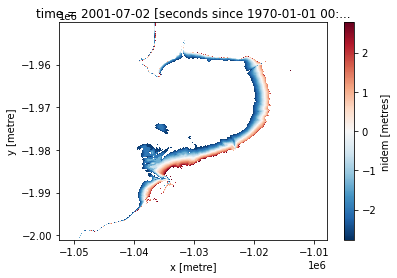

In [140]:
ds2.nidem.plot()

In [ ]:
## Next - convert nidem_df back to xarray and plot exposure

## Option to speed process: increase bin size of tideheights used in cumfreq calculation 
## perhaps from 0.02 to 0.5 or 0.1 (10 cm tide height). This should reduce the size of the 
## 'test' df by reducing the number of rows to iterate through





In [68]:
## Calculate the pc exposure per pixel for each filter
## Build empty xr.ds and append each new da during looping through WetDry

pxpc2 = ds2#.squeeze().reset_coords() ## Copy of NIDEM ds to append exposure results into

# for f in WetDry:

In [81]:
pxpc2.nidem.values
# for e in pxpc2.nidem.values:
#     print (e)

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [ ]:
for pxpc2.nidem.where(pxpc2.nidem >= 

In [82]:
## nidem to dataframe
nidem_df = ds2.nidem.to_dataframe()
nidem_df

spatial_ref  nidem
time       y          x                             
2001-07-02 -1950137.5 -1052537.5         3577    NaN
                      -1052512.5         3577    NaN
                      -1052487.5         3577    NaN
                      -1052462.5         3577    NaN
                      -1052437.5         3577    NaN
...                                       ...    ...
           -2001062.5 -1007937.5         3577    NaN
                      -1007912.5         3577    NaN
                      -1007887.5         3577    NaN
                      -1007862.5         3577    NaN
                      -1007837.5         3577    NaN

[3645982 rows x 2 columns]

In [83]:
test

,tideheight,cumfreq
0,-4.851027,0.000154
1,-4.830932,0.000308
2,-4.810838,0.000461
3,-4.790743,0.001077
4,-4.770648,0.002769
...,...,...
483,4.854648,99.997231
484,4.874743,99.998000
485,4.894838,99.998923
486,4.914932,99.999385
